# Keras 개발 Process

1. 입력 텐서(X)와 출력 텐서(y)로 이뤄진 **훈련 데이터를 정의**

2. 입력과 출력을 연결하는 Layer(층)으로 이뤄진 **네트워크(모델)을 정의**
    - Sequential 방식: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
    - Functional API 방식: 다양한 구조의 네트워크로 이뤄진 모델을 생성하는 방식
    - Subclass 방식: 네트워크를 정의하는 클래스를 구현.
    

3. **모델 Compile(컴파일)**
    - 모델이 Train(학습)할때 사용할 손실함수(Loss Function), 최적화기법(Optimizer), 학습과정을 모니터링할 평가지표(Metrics)를 설정
    
    > Compile: 실행할 수 있는 상태로 만들어 주는 것.

4. **Training(학습/훈련)**
    - Train dataset을 이용해 모델을 Train 시킨다.

# MNIST 이미지 분류 
- ### [MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4)(Modified National Institute of Standards and Technology) database
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

##### import

In [61]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [38]:
print(tf.__version__)
# seed 값 설정
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

2.11.0


##### MNIST dataset Loading

In [39]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()

In [40]:
train_image.shape, train_label.shape, test_image.shape, test_label.shape
# (60000, 28, 28) : (개수, 데이터 shape-28 28)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [41]:
# y값 확인
train_label[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

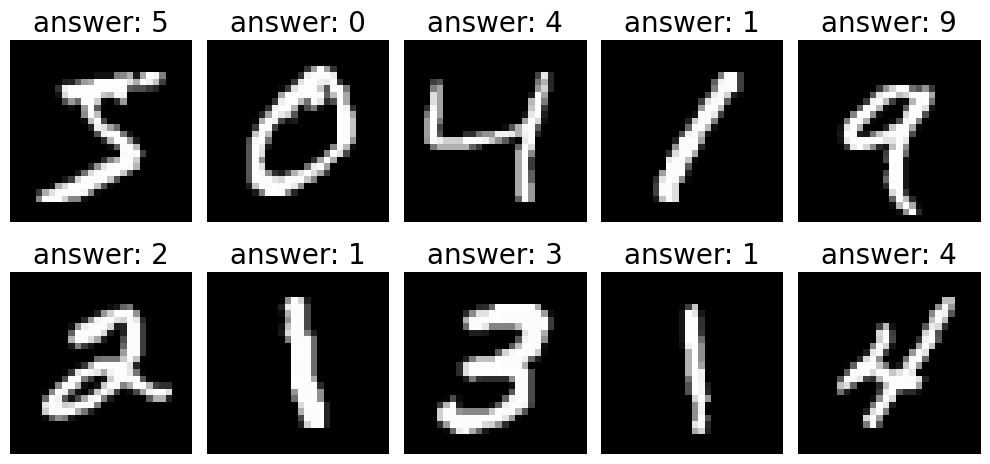

In [42]:
# X값 -image 확인
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_image[i], cmap='gray')
    plt.title(f'answer: {train_label[i]}', fontsize=20)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [79]:
train_image[0].min(), train_image[0].max()

(0, 255)

## 데이터 준비
- X (Input Data Image)
    - 0 ~ 1 사이의 값으로 정규화 시킨다.
- y (Output Data)
    - one hot encoding 처리
        - Label이 다중분류(Multi class classification)일 경우 One Hot Encoding 한다.
            - 딥러닝 모델이 각 Label별 확률을 출력하도록 정의 되기 때문에 y(정답)도 같은 형태로 만들어 줘야 한다.
    - Keras의 onehot encoding 처리 함수
        - tensorflow.keras.utils.to_categorical()

In [1]:
train_image.dtype

NameError: name 'train_image' is not defined

##### input image(X)를 정규화. 
- 이미지를 0 ~ 1 로 정규화 하고 타입을 float32로 변환

In [44]:
X_train = train_image.astype('float32')/255
X_test = test_image.astype('float32')/255

##### label(y)를 one hot encoding

In [45]:
np.unique(train_label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [46]:
y_train = keras.utils.to_categorical(train_label, num_classes=10)
y_test = keras.utils.to_categorical(test_label)

In [47]:
train_label[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [48]:
y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## 네트워크(모델) 정의
- Network : 전체 모델 구조

- units / node / Newrun
- 딥러닝 모델은 레이어를 쌓는다.
- 각각의 layer는 여러개의 unit 들로 이루어져 있다.

> - **즉, 각각의 unit들이 모여 layer가 되고 그 layer들이 모여 model이 된다**

>- 모델에 layer 들을 추가(쌓는다.)
>- 각 레이어는 이전 layer의 출력결과를 입력으로 받아서 처리한 뒤에 출력한다.
>- layer는 Unit / Node / Neuron들로 구성된다=> feature 들을 입력받아서 처리후 출력하는 함수.(unit = 함수)

In [50]:
model = keras.Sequential() # (빈)모델생성

# 첫번쨰 layer를 추가 => 첫번쨰: Inputlayer를 추가. => (모델의) 입력 데이터의 shape을 설정하는 역할.
model.add(keras.layers.InputLayer((28, 28)))

# 입력데이터를 1차원 배열로 변환. 즉, inputlayer에서 받은 데이터를 1차원으로 바꿔준다.
model.add(keras.layers.Flatten()) 

 # unit 256개로 이뤄진 layer를 생성. 각 unit은 선형회귀 (W * X + B) 계산을 처리.
model.add(keras.layers.Dense(units = 256)) 

model.add(keras.layers.ReLU()) # max(X, 0) => Activation(활성)함수 => 비선형 함수를 사용.
# ㄴ입력값 중 최대값을 반환(음수가 들어오면 0을 반환))

model.add(keras.layers.Dense(units = 128))

model.add(keras.layers.ReLU())

model.add(keras.layers.Dense(units = 10))

# Output layer => 모델의 출력 결과를 출력하는 layer
model.add(keras.layers.Softmax(name = 'output')) 

>- Sequential() 빈 모델생성
>- 28 * 28 짜리 Inputlayer 받는다
>- Flatten()으로 다차원 데이터를 1차원으로 바꾼다
>- 784개의 unit들이 256개가 있는 Dense layer에 들어간다.
>- Relu 함수를 거친다.
>- 256개의 unit들을 128개의 unit들이 있는 Dense layer로 이동.
>- Relu 함수를 거친다.
>- 128개의 unit들을 각각 10개의 unit들로 이동.
>- soft max()로 출력 

In [51]:
model2 = keras.Sequential([
    keras.layers.InputLayer((28, 28)),
    keras.layers.Flatten(),
    keras.layers.Dense(256),
    keras.layers.ReLU(),
    keras.layers.Dense(10),
    keras.layers.Softmax()
])

In [52]:
# 모델의 구조를 확인
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               200960    
                                                                 
 re_lu_7 (ReLU)              (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 re_lu_8 (ReLU)              (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                1290      
                                                                 
 output (Softmax)            (None, 10)               

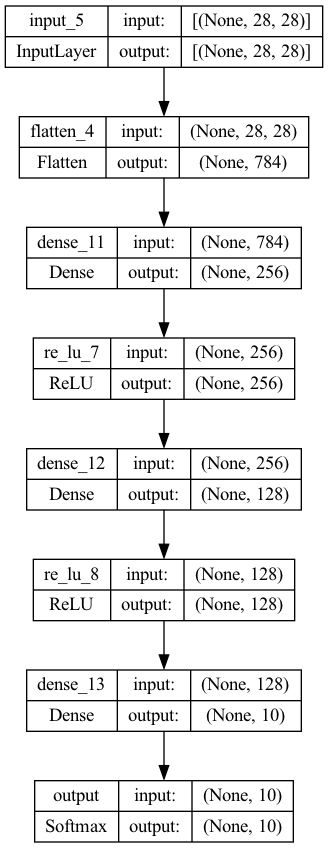

In [53]:
# 모델구조를 시각화 - graphviz
# pip install graphviz pydot pydotplus
keras.utils.plot_model(model, show_shapes = True, # layer의 input/output의 shape을 확인
                       to_file = 'model_shapes.png'
                      )

> None 은 batch_size를 의미한다.

## 컴파일 단계
- 정의된 딥러닝 모델을 학습할 수 있는 상태로 만들어 주기 위해 다음을 추가적으로 설정 한다.
    - Optimizer
    - 손실함수
    - 평가지표

In [54]:
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy']) 
# 학습로그, 모델 평가 할때 loss(loss함수가 계산한 오차값)와 같이 나올 평가지표

## 학습 (fit)
- model.fit()
    - 모델 학습 메소드. 
    - 학습과정의 Log를 History 객체로 반환한다.
- History : train 시 에폭별 평가지표값들을 모아서 제공.    

In [72]:
history = model.fit(X_train, y_train, # train dataset
 epochs = 10, # train dataset을 몇 번 반복해서 학습할 것인지.(문제를 몇번 보는지) // 1 에폭이 끝나면 값들을 한번 셔플한다.
 batch_size = 100, # 파라미터(weight - 학습대상)를 업데이터 하기 위한 데이터 단위. 
 # 업데이트 단위: step, 1step에 입력할 데이터 개수: batch_size (bath_size는 메모리가 허용하는 하는 높게 잡아주면 좋다=> 효율성 상승)
 validation_split = 0.3 # train set 중 validation으로 사용할 데이터 비율.(전체중 70은 train에, 30은 검증에 사용하겠다.)
         
         )

Epoch 1/10


2023-02-16 17:12:21.453764: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x7feea0642550
2023-02-16 17:12:21.453825: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x7feea0642550
2023-02-16 17:12:21.457052: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x7feea0642550
2023-02-16 17:12:21.457097: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x7feea0642550
2023-02-16 17:12:21.457922: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x7feea0642550
2023-02-16 17:12:21.457943: W tensorflow/core/framework/op_kernel.cc:1830] OP_RE

NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/nc/lry6d8ws417_mblykm_8wpc40000gn/T/ipykernel_52274/409783268.py", line 1, in <module>
      history = model.fit(X_train, y_train, # train dataset
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/seokminlee/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x7feea0642550
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_2639]

Epoch 1/10 # 현재 에폭 / 전체 에폭수 => 몉번째 에폭 결과
420 / 420 [============================] - 4s 8ms/step = loss: 0.3090 - accuracy: 0.9111 - val_loss: 0.1656 - val

            
>- 420 / 420: 현재 학습중인 step / 전체 step    
>- 4s: 에폭당 걸린 학습시간(4s) 
>- 8ms: 스텝당 걸린 학습 시간(8ms)
    
>- train set 평가결과
>- loss: 0.3090 - loss(손실 - 오차값)
>- accuracy: 0.9111 - 컴파일 때 지정한 metrics의 결과.
    
>- validation set 평과 결과
>- val_loss: 0.1656 - val_accuracy: 0.9514
        
> - 학습을 시키려면 꼭!! 컴파일을 해야만 한다.

In [80]:
print(type(history)) # 학습 과정의 평가지표들 등의 정보를 저장한 객체.
print('학습 에폭리스트:', history.epoch)
print('에폭수, 에폭당 step수: ', history.params)

NameError: name 'history' is not defined

In [65]:
history.history

NameError: name 'history' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize = (15, 6))
plt.suptitle('학습 평가 결과') # figure 제목

plt.subplot(1 ,2 ,1)
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.title('Loss')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.title('Accuracy')

plt.legend()
plt.tight_layout()
plt.show()


- train은 계속 좋아진다.
- val
- 에폭 수도 과적합이랑 관계가 있다.

##### History 시각화

## 테스트셋 평가

In [ ]:
result = model.evaluate(X_test, y_test) # loss, compile시 지정한 metrics로 평가

In [ ]:
result

## 새로운 데이터 추론
- 새로운 데이터를 추론하기 전에 학습데이터에 했던 전처리과정을 동일하게 적용 한 뒤 추론한다.

### 추론 메소드
- predict()
    - **분류:** 각 클래스 별 확률 반환
    - **회귀:** 최종 예측 결과
- 분류문제일때 predict() 결과에서 class label 출력하기    
    - 이진 분류(binary classification)
        - `numpy.where(model.predict(x) > 0.5, 1, 0).astype("int32")`
    - 다중클래스 분류(multi-class classification)
        - `numpy.argmax(model.predict(x), axis=1)`

> - 2진분류 => 양성확률
> - 다중븐류 => class별 확률

In [73]:
X_new = X_test[:3]
X_new.shape

(3, 28, 28)

In [75]:
pred = model.predict(X_new) # 추론: (개수, 데이터 shape)

1/1 [==============================] - 0s 18ms/step


In [76]:
print(pred.shape)
pred

(3, 10)


array([[0.10823568, 0.07326891, 0.11517157, 0.07150222, 0.0951796 ,
        0.08522029, 0.08927017, 0.09706014, 0.15800157, 0.10708982],
       [0.13981922, 0.07941875, 0.19197282, 0.07998203, 0.07329673,
        0.10702574, 0.12374052, 0.07838212, 0.07524083, 0.05112123],
       [0.10031575, 0.09945421, 0.1617215 , 0.10537612, 0.07471664,
        0.08089034, 0.10962319, 0.07920772, 0.09773917, 0.0909554 ]],
      dtype=float32)

In [77]:
np.argmax(pred, axis = -1)

array([8, 2, 2])

In [78]:
np.argmax(y_test[:3], axis = -1)

array([7, 2, 1])

# Todo
1. opencv로 그림판 숫자이미지들을 읽는다. (grayscale)
2. 28 X 28 로 resize
3. 모델을 이용해서 추론